FCS experiment analysis.
Data collected 24 October 2023.
Used atto 488 at 4 different concentrations to determine focal volume and structure parameter.
Measured Bem1-GFP in A.p. cells (multiple morphologies) and S.c. cells, cytoplasmic measurements only.
May FCS datasets have corresponding confocal images showing regions analyzed (before and after FCS).
Forgot to align pin hole so results may be less than perfect.

In [1]:
import fcsfiles as fcs # Small one-man repo, likely has bugs
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import inspect

In [8]:
def fcs_extract(data, replicates=range(0,10)):
    times_counts = data['FcsData']['FcsEntry'][0]['FcsDataSet']['CountRateArray'][:,0]
    times_corr = data['FcsData']['FcsEntry'][0]['FcsDataSet']['CorrelationArray'][:,0]
    bins_hist = data['FcsData']['FcsEntry'][0]['FcsDataSet']["PhotonCountHistogramArray"][:,0]
    for i in replicates:
        tmp_bins_hist = data['FcsData']['FcsEntry'][i]['FcsDataSet']["PhotonCountHistogramArray"][:,0]
        if tmp_bins_hist.shape[0] > bins_hist.shape[0]:
            bins_hist = tmp_bins_hist
    all_counts = np.zeros((len(times_counts), len(replicates)))
    all_corr = np.zeros((len(times_corr), len(replicates)))
    sum_hist = np.zeros(len(bins_hist))
    for n, i in enumerate(replicates):
        all_counts[:,n] = data['FcsData']['FcsEntry'][i]['FcsDataSet']['CountRateArray'][:,1]
        all_corr[:,n] = data['FcsData']['FcsEntry'][i]['FcsDataSet']['CorrelationArray'][:,1]
        vals_to_add = data['FcsData']['FcsEntry'][i]['FcsDataSet']['PhotonCountHistogramArray'][:,1]
        sum_hist[0:len(vals_to_add)] += vals_to_add
    mean_corr = np.mean(all_corr, axis=1)
    return times_counts, all_counts, times_corr, all_corr, mean_corr, bins_hist, sum_hist

In [3]:
def plot3(times_counts, all_counts, times_corr, all_corr, mean_corr, bins_hist, sum_hist):
    fig, axs = plt.subplots(3, 1, figsize=(8,8))
    fig.suptitle(f'FCS Data: {data["FcsData"]["Name"]}')
    axs[0].stairs(sum_hist, np.insert(bins_hist, 0, 0));
    axs[0].set_title("Photon Count Histogram (PCH)")
    axs[1].plot(times_counts, all_counts, alpha=0.2);
    axs[1].plot(times_counts, all_counts[:,0], linewidth=0.8, color="C0");
    axs[1].set_title("Fluoresence Trace")
    axs[2].set_xscale("log")
    mean_corr = np.mean(all_corr, axis=1)
    axs[2].plot(times_corr, all_corr, alpha=0.1)
    axs[2].plot(times_corr, mean_corr, linewidth=3, color="C0")
    axs[2].set_title("Correlation Curve")
    fig.tight_layout()

In [7]:
# Load calibration data
data = fcs.ConfoCor3Fcs('atto488_2nM_laser0p2.fcs')

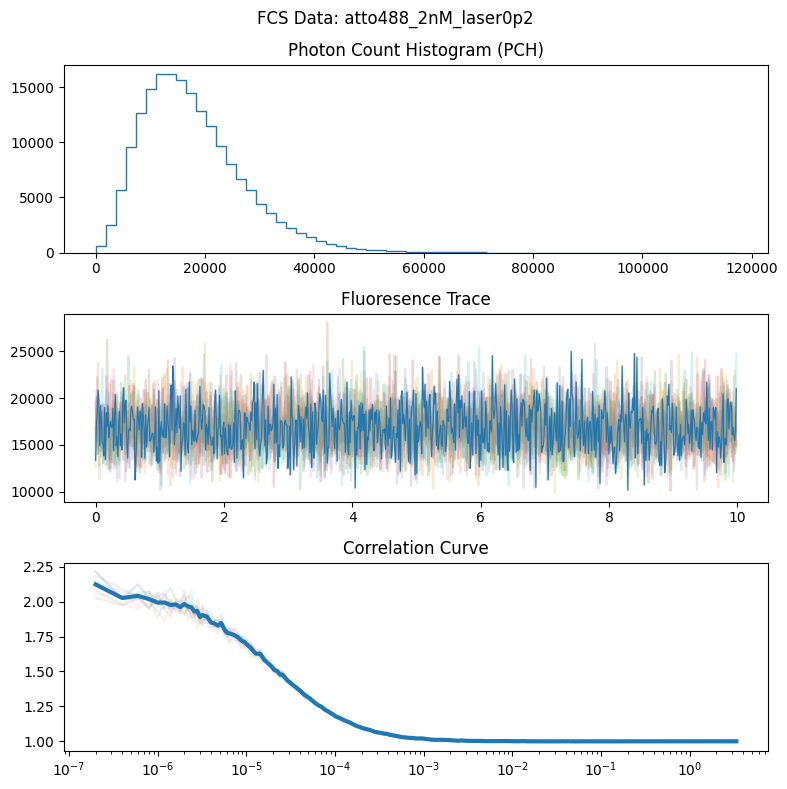

In [8]:
times_counts, all_counts, times_corr, all_corr, mean_corr, bins_hist, sum_hist = fcs_extract(data)
plot3(times_counts, all_counts, times_corr, all_corr, mean_corr, bins_hist, sum_hist)

In [46]:
def plot_fit(xdata, ydata, f, text="2nM atto488 at 0.2% laser power"):
    fit = curve_fit(f, xdata, ydata, p0=None)
    popt, pcov = fit
    perr = np.sqrt(np.diag(pcov))
    fig, axs = plt.subplots(3, 1, figsize=(8,8))
    axs[0].plot(xdata, f(xdata, *popt))
    axs[0].set_xscale("log")
    axs[0].plot(xdata, ydata, color="C03")
    axs[0].set_title(f"{text}")
    residuals = ydata - f(xdata, *popt)
    axs[1].plot(xdata, residuals, color="C03")
    axs[1].set_xscale("log")
    axs[1].set_title(f"Residuals")
    axs[1].axhline(y = 0, linestyle = '-') 
    axs[2].bar([f"N={round(popt[0],3)}", f"tauD={round(popt[1],6)}", f"K={round(popt[2], 3)}"], [popt[0], popt[1], popt[2]], yerr=perr)
    axs[2].set_yscale("log")
    fig.tight_layout()

In [11]:
def f(tau, N, tauD, k):
    return 1 + (1/N) * (1/(1+tau/tauD)) * (1/(1+(tau/tauD)*(k**2)))**0.5
def f_triplet(tau, N, tauD, k, tauT):
    return 1 + (1/N) * (1/(1+tau/tauD)) * (1/(1+(tau/tauD)*(k**2)))**0.5 * (1-tau+tau*np.e**(-tau/tauT))
def f_anomalous(tau, N, tauD, k, alpha):
    return 1 + (1/N) * (1/(1+(tau/tauD)**alpha)) * (1/(1+((tau/tauD)**alpha)*(k**2)))**0.5

/tmp/ipykernel_102718/730859934.py:2: RuntimeWarning: invalid value encountered in sqrt
  return 1 + (1/N) * (1/(1+tau/tauD)) * (1/(1+(tau/tauD)*(k**2)))**0.5


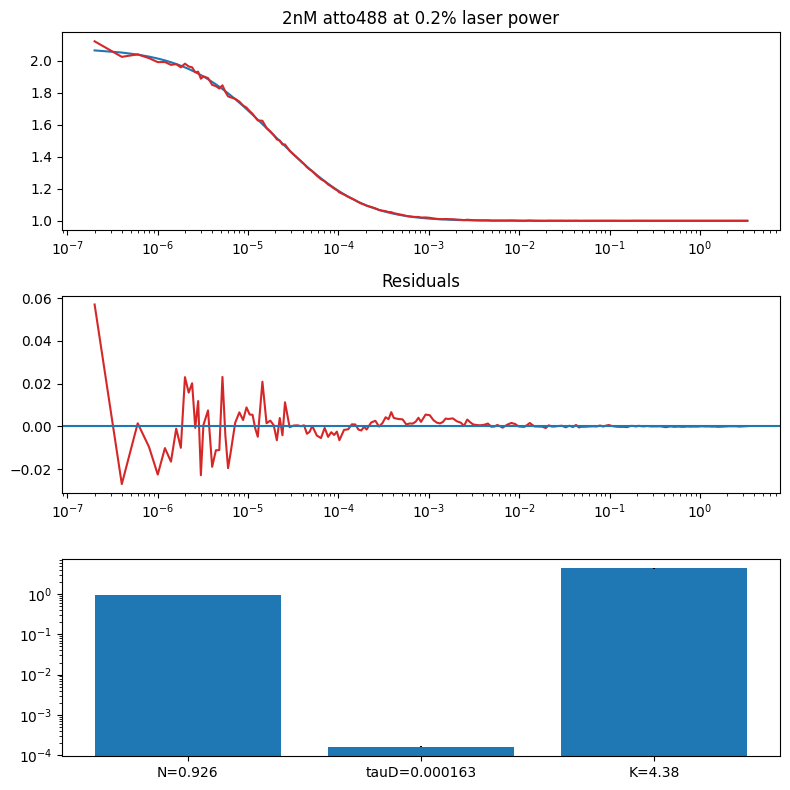

In [57]:
plot_fit(times_corr, mean_corr, f)

/tmp/ipykernel_102718/730859934.py:2: RuntimeWarning: invalid value encountered in sqrt
  return 1 + (1/N) * (1/(1+tau/tauD)) * (1/(1+(tau/tauD)*(k**2)))**0.5


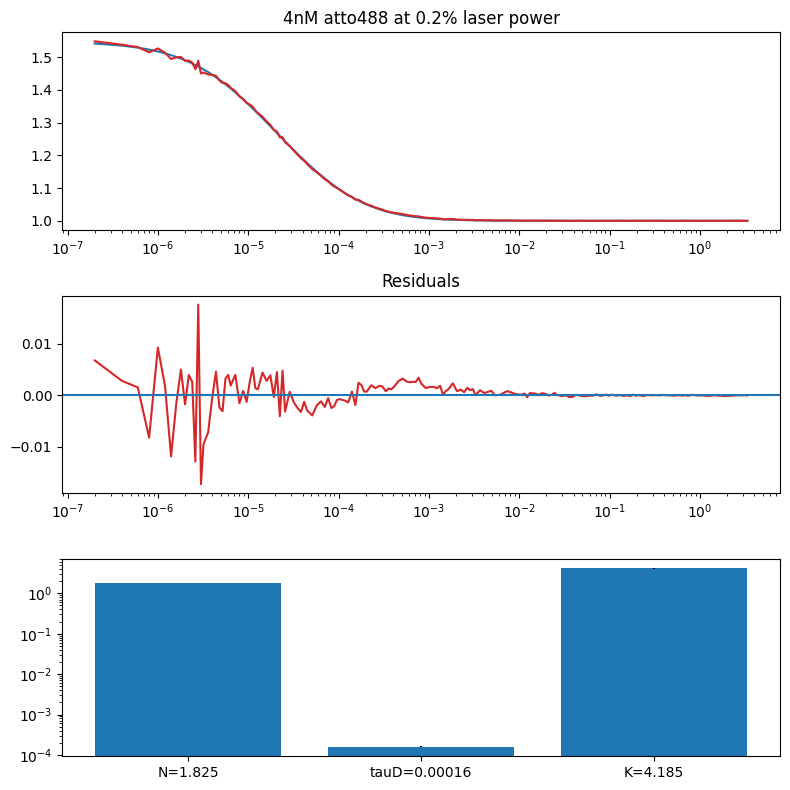

In [61]:
data = fcs.ConfoCor3Fcs('atto488_4nM_laser0p2.fcs')
times_counts, all_counts, times_corr, all_corr, mean_corr, bins_hist, sum_hist = fcs_extract(data)
plot_fit(times_corr, mean_corr, f, text="4nM atto488 at 0.2% laser power")

/tmp/ipykernel_102718/730859934.py:2: RuntimeWarning: invalid value encountered in sqrt
  return 1 + (1/N) * (1/(1+tau/tauD)) * (1/(1+(tau/tauD)*(k**2)))**0.5


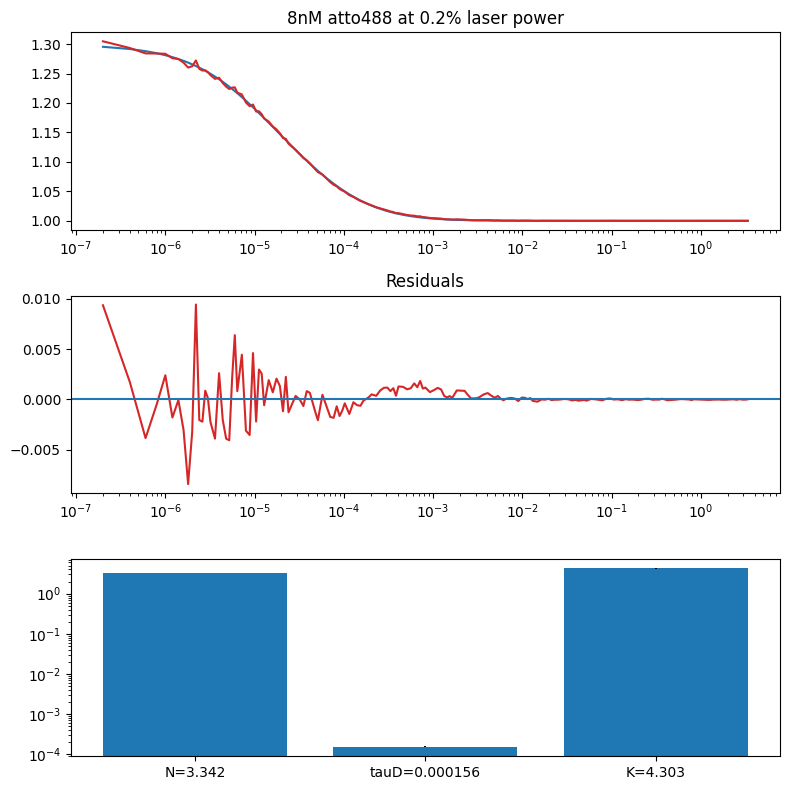

In [62]:
data = fcs.ConfoCor3Fcs('atto488_8nM_laser0p2.fcs')
times_counts, all_counts, times_corr, all_corr, mean_corr, bins_hist, sum_hist = fcs_extract(data)
plot_fit(times_corr, mean_corr, f, text="8nM atto488 at 0.2% laser power")

/tmp/ipykernel_102718/730859934.py:2: RuntimeWarning: invalid value encountered in sqrt
  return 1 + (1/N) * (1/(1+tau/tauD)) * (1/(1+(tau/tauD)*(k**2)))**0.5


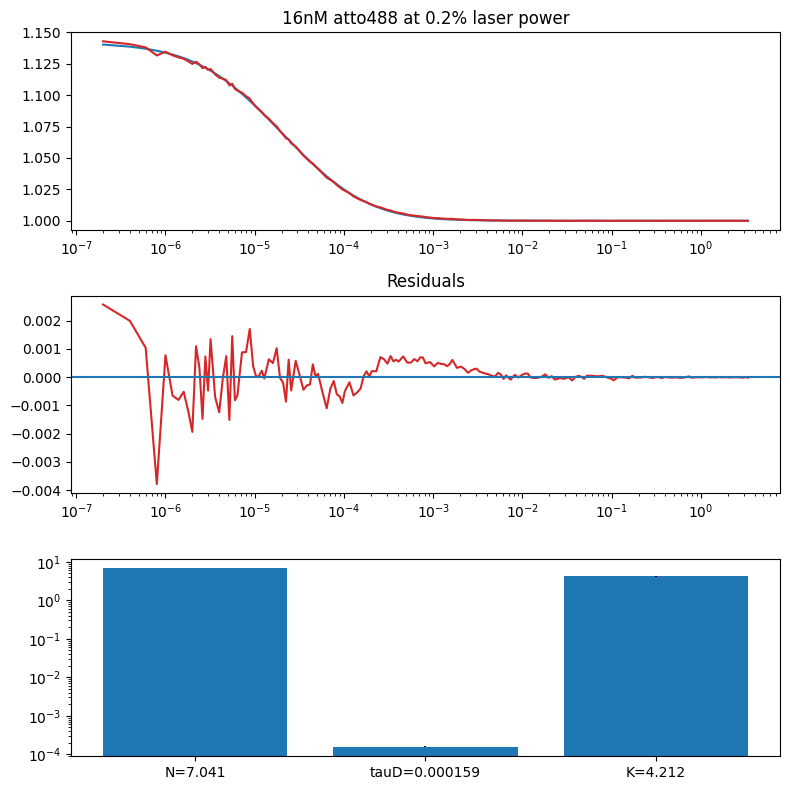

In [63]:
data = fcs.ConfoCor3Fcs('atto488_16nM_laser0p2.fcs')
times_counts, all_counts, times_corr, all_corr, mean_corr, bins_hist, sum_hist = fcs_extract(data)
plot_fit(times_corr, mean_corr, f, text="16nM atto488 at 0.2% laser power")

In [16]:
def fcs_fit_params(times_corr, mean_corr, func, conc):
    fit = curve_fit(func, times_corr, mean_corr, p0=None)
    popt, pcov = fit
    N, tauD, K = popt
    C = conc
    w3 = N/(C*np.pi**(3/2)*K)
    w_by_conc = w3**(1./3)
    w_by_diff = tauD*4*400
    return w_by_conc, w_by_diff, tauD, K, N

In [23]:
data2 = fcs.ConfoCor3Fcs('atto488_2nM_laser0p2.fcs')
data4 = fcs.ConfoCor3Fcs('atto488_4nM_laser0p2.fcs')
data8 = fcs.ConfoCor3Fcs('atto488_8nM_laser0p2.fcs')
data16 = fcs.ConfoCor3Fcs('atto488_16nM_laser0p2.fcs')

all_data = [data2, data4, data8, data16]

all_N = []
all_K= []
all_tauD = []
all_w_conc = []
all_w_diff = []
for n, data in enumerate(all_data):
    times_counts, all_counts, times_corr, all_corr, mean_corr, bins_hist, sum_hist = fcs_extract(data)
    w_bc, w_bd, tauD, K, N = fcs_fit_params(times_corr, mean_corr, f, 2**(n+1))
    all_K.append(K)
    all_tauD.append(tauD)
    all_w_conc.append(w_bc)
    all_w_diff.append(w_bd)
    all_N.append(N)


/tmp/ipykernel_104574/336639674.py:2: RuntimeWarning: invalid value encountered in sqrt
  return 1 + (1/N) * (1/(1+tau/tauD)) * (1/(1+(tau/tauD)*(k**2)))**0.5


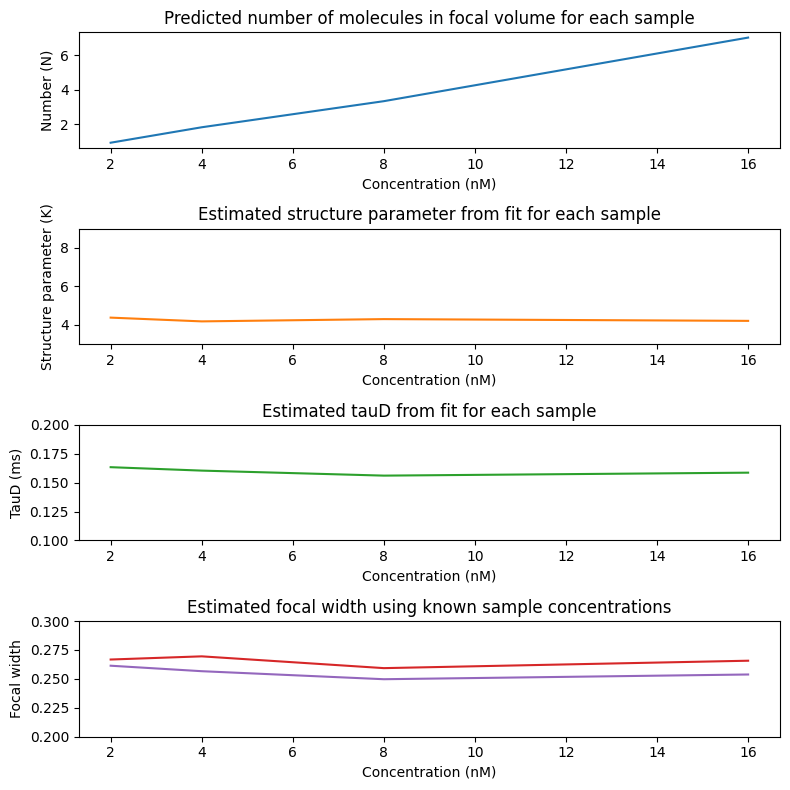

In [29]:
nM = [2.,4.,8.,16.]
labels = ["2nM", "4nM", "8nM", "16nM"]
fig, axs = plt.subplots(4, 1, figsize=(8,8))
axs[0].plot(nM, all_N, color="C00")
axs[0].set_xlabel("Concentration (nM)")
axs[0].set_ylabel("Number (N)")
axs[0].set_title("Predicted number of molecules in focal volume for each sample")
axs[1].plot(nM,all_K, color="C01")
axs[1].set_xlabel("Concentration (nM)")
axs[1].set_ylabel("Structure parameter (K)")
axs[1].set_title("Estimated structure parameter from fit for each sample")
axs[1].set_ylim(3,9)
axs[2].plot(nM,np.multiply(all_tauD, 1000), color="C02")
axs[2].set_xlabel("Concentration (nM)")
axs[2].set_ylabel("TauD (ms)")
axs[2].set_title("Estimated tauD from fit for each sample")
axs[2].set_ylim(0.1,0.2)
axs[3].plot(nM, all_w_conc, color="C03")
axs[3].plot(nM, all_w_diff, color="C04")
axs[3].set_xlabel("Concentration (nM)")
axs[3].set_ylabel("Focal width")
axs[3].set_title("Estimated focal width using known sample concentrations")
axs[3].set_ylim(0.2,0.3)
fig.tight_layout()

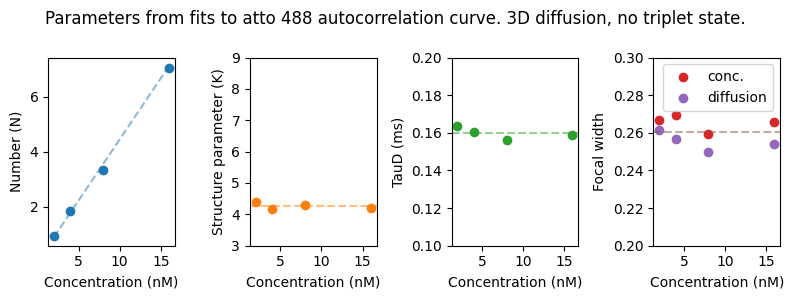

In [94]:
nM = [2.,4.,8.,16.]
labels = ["2nM", "4nM", "8nM", "16nM"]
fig, axs = plt.subplots(1, 4, figsize=(8,3))
mean_NbyC = np.mean(np.divide(all_N,nM))
N_line = np.multiply(nM,mean_NbyC)
axs[0].plot(nM, N_line, "--", alpha=0.5, color="C00")
axs[0].scatter(nM, all_N, color="C00")
axs[0].set_xlabel("Concentration (nM)")
axs[0].set_ylabel("Number (N)")
axs[1].axhline(y = np.mean(all_K), color="C01", alpha=0.5, linestyle = '--') 
axs[1].scatter(nM,all_K, color="C01")
axs[1].set_xlabel("Concentration (nM)")
axs[1].set_ylabel("Structure parameter (K)")
axs[1].set_ylim(3,9)
axs[2].axhline(y = 1000*np.mean(all_tauD), color="C02", alpha=0.5, linestyle = '--') 
axs[2].scatter(nM,np.multiply(all_tauD, 1000), color="C02")
axs[2].set_xlabel("Concentration (nM)")
axs[2].set_ylabel("TauD (ms)")
axs[2].set_ylim(0.1,0.2)
axs[3].axhline(y = np.mean(all_w_conc + all_w_diff), color="C05", alpha=0.5, linestyle = '--') 
axs[3].scatter(nM, all_w_conc, color="C03", label="conc.")
axs[3].scatter(nM, all_w_diff, color="C04", label="diffusion")
axs[3].set_xlabel("Concentration (nM)")
axs[3].set_ylabel("Focal width")
axs[3].set_ylim(0.2,0.3)
fig.suptitle("Parameters from fits to atto 488 autocorrelation curve. 3D diffusion, no triplet state.")
plt.legend()
plt.tight_layout()

In [80]:
print(np.mean(all_w_conc + all_w_diff))

0.2603651848599613


In [99]:
def plot_fit(xdata, ydata, func, text="2nM atto488 at 0.2% laser power", p=None):
    fit = curve_fit(func, xdata, ydata, p0=p)
    popt, pcov = fit
    perr = np.sqrt(np.diag(pcov))
    fig, axs = plt.subplots(3, 1, figsize=(8,8))
    axs[0].plot(xdata, func(xdata, *popt))
    axs[0].set_xscale("log")
    axs[0].plot(xdata, ydata, color="C03")
    axs[0].set_title(f"{text}")
    residuals = ydata - func(xdata, *popt)
    axs[1].plot(xdata, residuals, color="C03")
    axs[1].set_xscale("log")
    axs[1].set_title(f"Residuals")
    axs[1].axhline(y = 0, linestyle = '-') 
    params = inspect.getfullargspec(func).args[1:]
    popt[1] = popt[1]*1000
    bar = axs[2].bar(params, popt, label=popt)
    axs[2].bar_label(bar)
    axs[2].set_yscale("log")
    fig.tight_layout()

/tmp/ipykernel_103551/336639674.py:6: RuntimeWarning: invalid value encountered in power
  return 1 + (1/N) * (1/(1+(tau/tauD)**alpha)) * (1/(1+((tau/tauD)**alpha)*(k**2)))**0.5


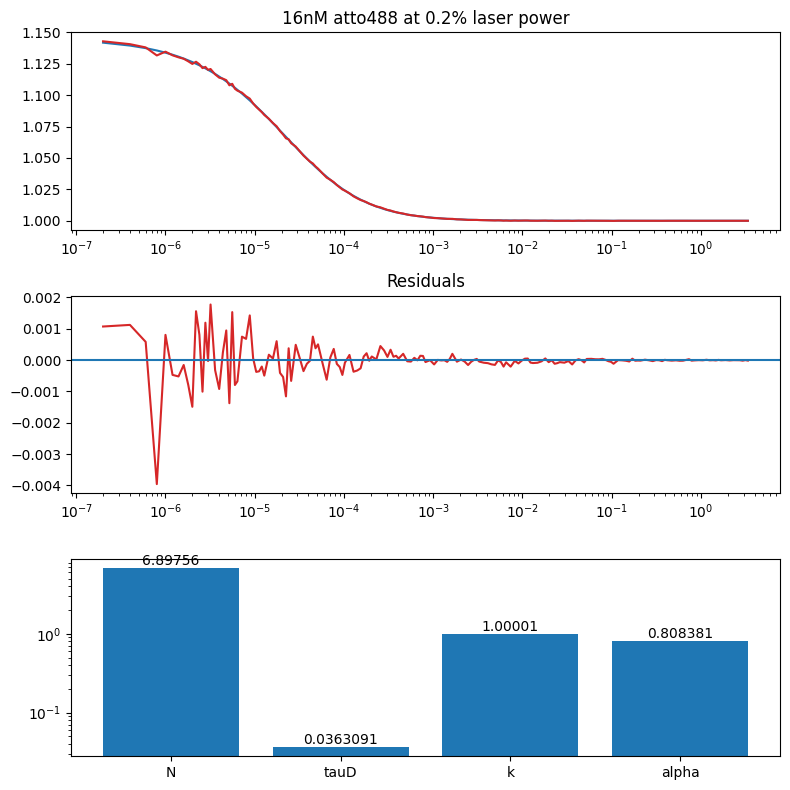

In [32]:
data = fcs.ConfoCor3Fcs('atto488_16nM_laser0p2.fcs')
times_counts, all_counts, times_corr, all_corr, mean_corr, bins_hist, sum_hist = fcs_extract(data)
plot_fit(times_corr, mean_corr, func=f_anomalous, text="16nM atto488 at 0.2% laser power")

In [36]:
sample = fcs.ConfoCor3Fcs('ApBem1GFP_expt6_6roi_laser0p05_yeastOnly.fcs')

In [97]:
# Models with fixed parameters from fitting above
def f(tau, N, tauD):
    K = 4.2
    return 1 + (1/N) * (1/(1+tau/tauD)) * (1/(1+(tau/tauD)*(K**2)))**0.5
def f_anomalous(tau, N, tauD, alpha):
    return 1 + (1/N) * (1/(1+(tau/tauD)**alpha)) * (1/(1+((tau/tauD)**alpha)*(4.2**2)))**0.5
def two_comp(tau, N, tauD1, tauD2, F1, Q1):
    g1 = (1/(1+tau/tauD1)) * (1/(1+(tau/tauD1)*(4.2**2)))**0.5
    g2 = (1/(1+tau/tauD2)) * (1/(1+(tau/tauD2)*(4.2**2)))**0.5
    G = ((Q1**2)*F1*g1 + (Q1**2)*(1-F1)*g2) / (N*((Q1*F1 + Q1*(1-F1))**2))
    return G

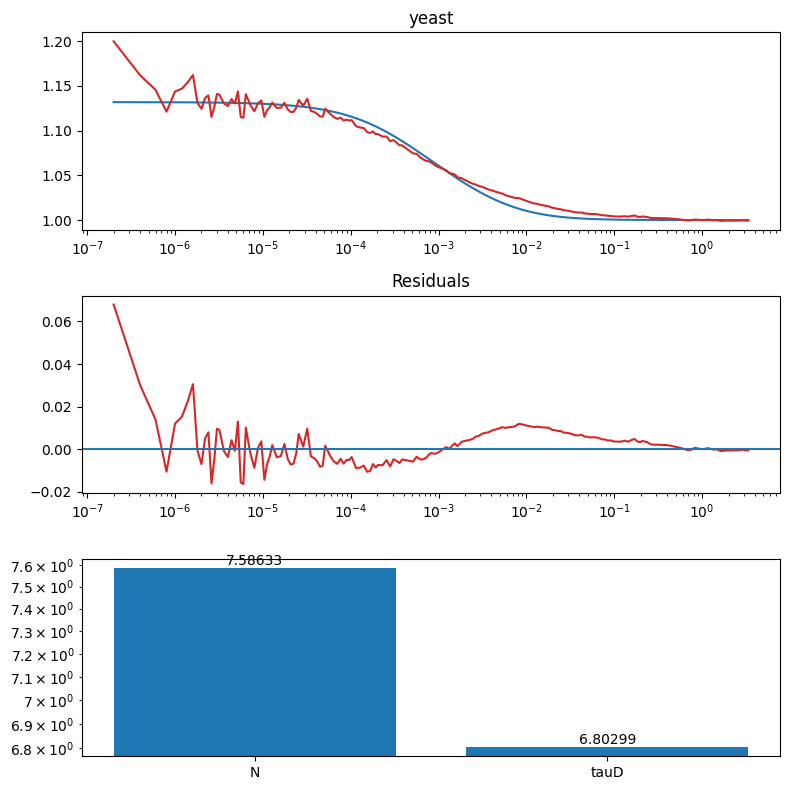

In [95]:
times_counts, all_counts, times_corr, all_corr, mean_corr, bins_hist, sum_hist = fcs_extract(sample, replicates=range(1,10))
plot_fit(times_corr, mean_corr, f, text="yeast")

/tmp/ipykernel_103551/584733761.py:4: RuntimeWarning: invalid value encountered in power
  return 1 + (1/N) * (1/(1+(tau/tauD)**alpha)) * (1/(1+((tau/tauD)**alpha)*(4.2**2)))**0.5


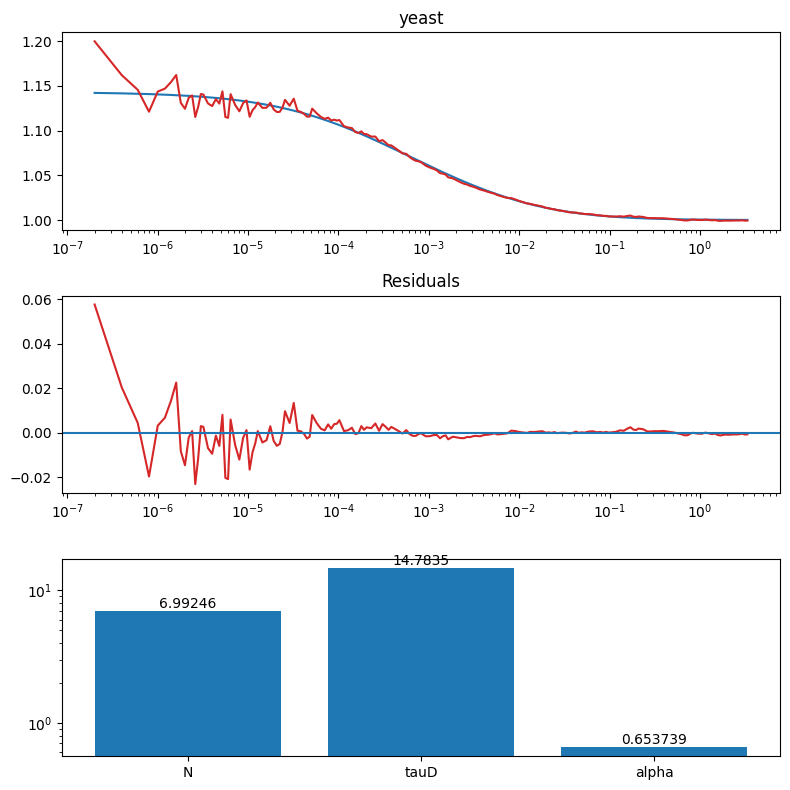

In [98]:
plot_fit(times_corr, mean_corr, f_anomalous, text="yeast")

In [106]:
times_counts, all_counts, times_corr, all_corr, mean_corr, bins_hist, sum_hist = fcs_extract(sample, replicates=range(1,10))

def fcs_constarined_fit(times_corr, mean_corr, func):
    fit = curve_fit(func, times_corr, mean_corr, p0=None)
    popt, pcov = fit
    N, tauD = popt
    w = 0.26
    D = (w**2) / (4*tauD)
    C = N / (np.pi**(3/2)*K*w**3)
    return D, C

fcs_constarined_fit(times_corr, mean_corr, f)

(2.484203027295081, 18.404217145061722)

In [157]:
yeastD = []
yeastC = [] 
n = 0
for i in range(6):
    frames = range(10*i+1+n, 10*i+9+n)
    times_counts, all_counts, times_corr, all_corr, mean_corr, bins_hist, sum_hist = fcs_extract(sample, replicates=frames)
    n += 1 # because there is a buffer frame between sets.
    D, C = fcs_constarined_fit(times_corr, mean_corr, f)
    yeastD.append(D)
    yeastC.append(C)

/tmp/ipykernel_104574/58568743.py:4: RuntimeWarning: invalid value encountered in sqrt
  return 1 + (1/N) * (1/(1+tau/tauD)) * (1/(1+(tau/tauD)*(K**2)))**0.5


In [122]:
moms = fcs.ConfoCor3Fcs('ApBem1GFP_expt7_3roi_laser0p05_momsOnly.fcs')

In [158]:
momD = []
momC = [] 
n = 0
for i in range(3):
    frames = range(10*i+1+n, 10*i+9+n)
    times_counts, all_counts, times_corr, all_corr, mean_corr, bins_hist, sum_hist = fcs_extract(moms, replicates=frames)
    n += 1 # because there is a buffer frame between sets.
    D, C = fcs_constarined_fit(times_corr, mean_corr, f)
    momD.append(D)
    momC.append(C)

In [119]:
sacch = fcs.ConfoCor3Fcs('ScBem1GFP_expt2_3roi_laser0p05.fcs')

In [159]:
sacchD = []
sacchC = [] 
n = 0
for i in range(3):
    if i ==1:
        continue
    frames = range(10*i+1+n, 10*i+9+n)
    times_counts, all_counts, times_corr, all_corr, mean_corr, bins_hist, sum_hist = fcs_extract(sacch, replicates=frames)
    n += 1 # because there is a buffer frame between sets.
    D, C = fcs_constarined_fit(times_corr, mean_corr, f)
    sacchD.append(D)
    sacchC.append(C)
data = fcs.ConfoCor3Fcs('ScBem1GFP_expt1_1roi_laser0p05.fcs')
times_counts, all_counts, times_corr, all_corr, mean_corr, bins_hist, sum_hist = fcs_extract(data, replicates=(1,9))
D, C = fcs_constarined_fit(times_corr, mean_corr, f)
sacchD.append(D)
sacchC.append(C)

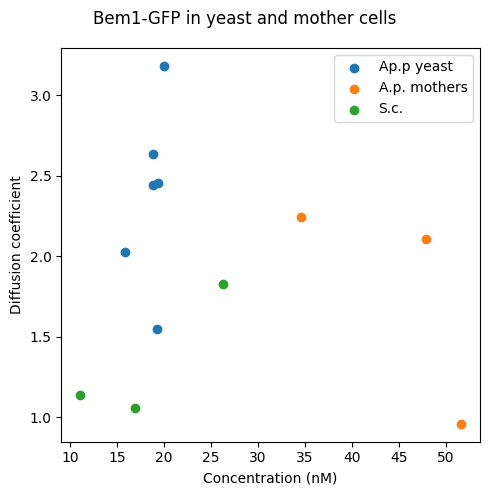

In [160]:
fig, axs = plt.subplots(1, 1, figsize=(5,5))
axs.scatter(yeastC, yeastD, color="C00", label="Ap.p yeast")
axs.scatter(momC, momD, color="C01", label="A.p. mothers")
axs.scatter(sacchC, sacchD, color="C02", label="S.c.")
axs.set_xlabel("Concentration (nM)")
axs.set_ylabel("Diffusion coefficient")
fig.suptitle("Bem1-GFP in yeast and mother cells")
plt.legend()
plt.tight_layout()

In [51]:
def fcs_constarined_fit2(times_corr, mean_corr, func):
    fit = curve_fit(func, times_corr, mean_corr, p0=None)
    popt, pcov = fit
    N, tauD, alpha = popt
    w = 0.26
    D = (w**2) / (4*tauD)
    C = N / (np.pi**(3/2)*K*w**3)
    return D, C, alpha

n = 0
for i in range(6):
    frames = range(10*i+1+n, 10*i+10+n)
    times_counts, all_counts, times_corr, all_corr, mean_corr, bins_hist, sum_hist = fcs_extract(sample, replicates=frames)
    n += 1 # because there is a buffer frame between sets.
    D, C, alpha = fcs_constarined_fit2(times_corr, mean_corr, f_anomalous)
    print(D, C, alpha)

1.1431649838605675 16.96350732000735 0.6537392597288021
0.7774107537071997 12.831807369698764 0.553035892089122
0.4375025950565055 16.06208123614343 0.5035744941945696
1.2713414942770225 17.46000624599284 0.6689672425763975
1.7112903070006305 18.091371151694073 0.6845284919970137
0.9141910785208662 16.45619545862161 0.5678971412317266


/tmp/ipykernel_104574/58568743.py:6: RuntimeWarning: invalid value encountered in power
  return 1 + (1/N) * (1/(1+(tau/tauD)**alpha)) * (1/(1+((tau/tauD)**alpha)*(4.2**2)))**0.5


IndexError: index 2 is out of bounds for axis 0 with size 2

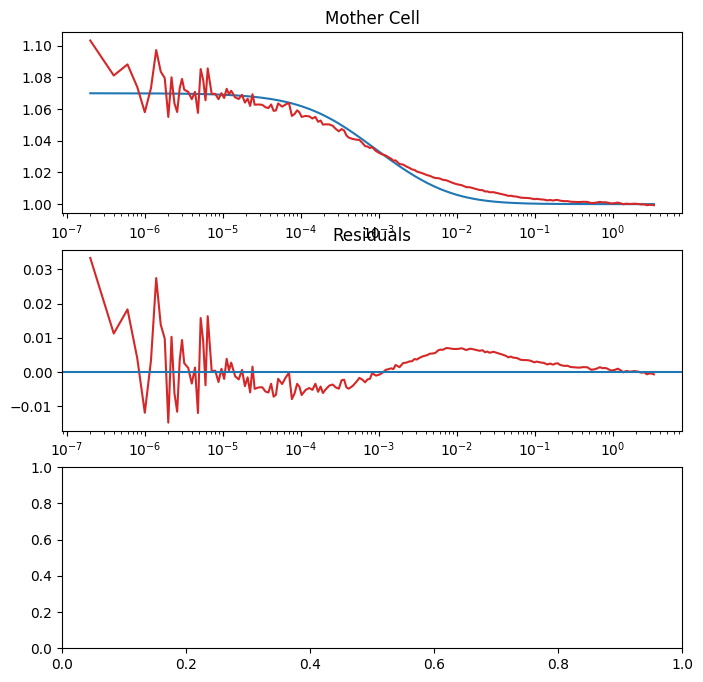

In [48]:
times_counts, all_counts, times_corr, all_corr, mean_corr, bins_hist, sum_hist = fcs_extract(moms, replicates=range(1,10))
plot_fit(times_corr, mean_corr, f, text="Mother Cell")

In [53]:
def fcs_constarined_fit(times_corr, mean_corr, func):
    fit = curve_fit(func, times_corr, mean_corr, p0=None)
    popt, pcov = fit
    N, tauD, alpha = popt
    w = 0.26
    D = (w**2) / (4*tauD)
    C = N / (np.pi**(3/2)*K*w**3)
    return D, C, alpha

n = 0
for i in range(3):
    frames = range(10*i+1+n, 10*i+10+n)
    times_counts, all_counts, times_corr, all_corr, mean_corr, bins_hist, sum_hist = fcs_extract(moms, replicates=frames)
    n += 1 # because there is a buffer frame between sets.
    D, C, alpha = fcs_constarined_fit(times_corr, mean_corr, f_anomalous)
    print(D, C, alpha)

0.8729553710268518 30.84898735757963 0.5836937395814132
0.1829348474669088 33.5819322646192 0.3285948650945202
0.8515975767920102 42.78386483674686 0.6117023422912614


/tmp/ipykernel_104574/58568743.py:6: RuntimeWarning: invalid value encountered in power
  return 1 + (1/N) * (1/(1+(tau/tauD)**alpha)) * (1/(1+((tau/tauD)**alpha)*(4.2**2)))**0.5


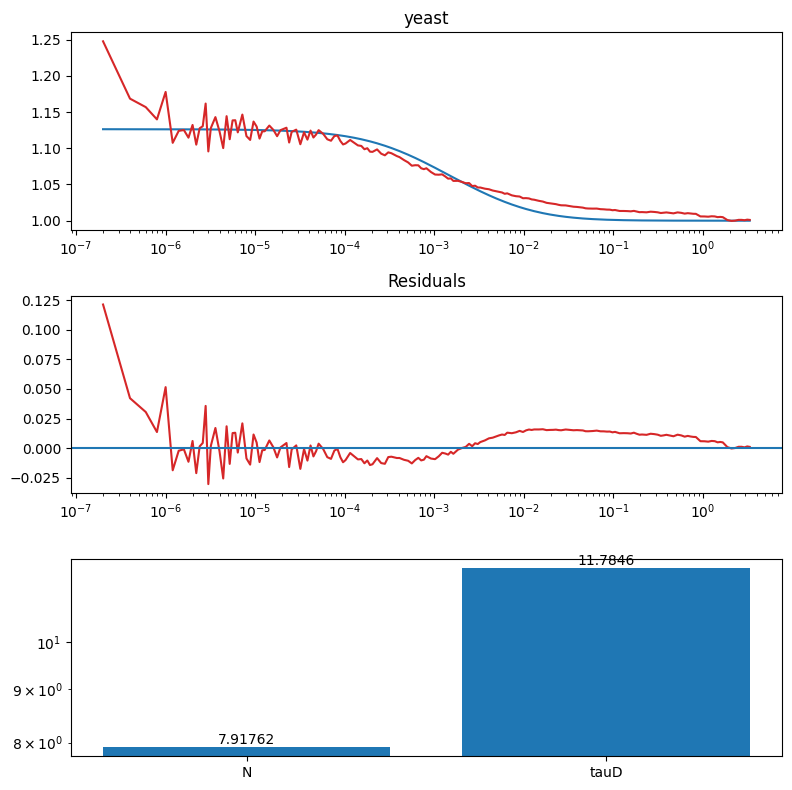

In [105]:
sample = fcs.ConfoCor3Fcs('ApBem1GFP_expt6_6roi_laser0p05_yeastOnly.fcs')
times_counts, all_counts, times_corr, all_corr, mean_corr, bins_hist, sum_hist = fcs_extract(sample, replicates=range(22,32))
plot_fit(times_corr, mean_corr, f, text="yeast")

/tmp/ipykernel_104574/58568743.py:6: RuntimeWarning: invalid value encountered in power
  return 1 + (1/N) * (1/(1+(tau/tauD)**alpha)) * (1/(1+((tau/tauD)**alpha)*(4.2**2)))**0.5


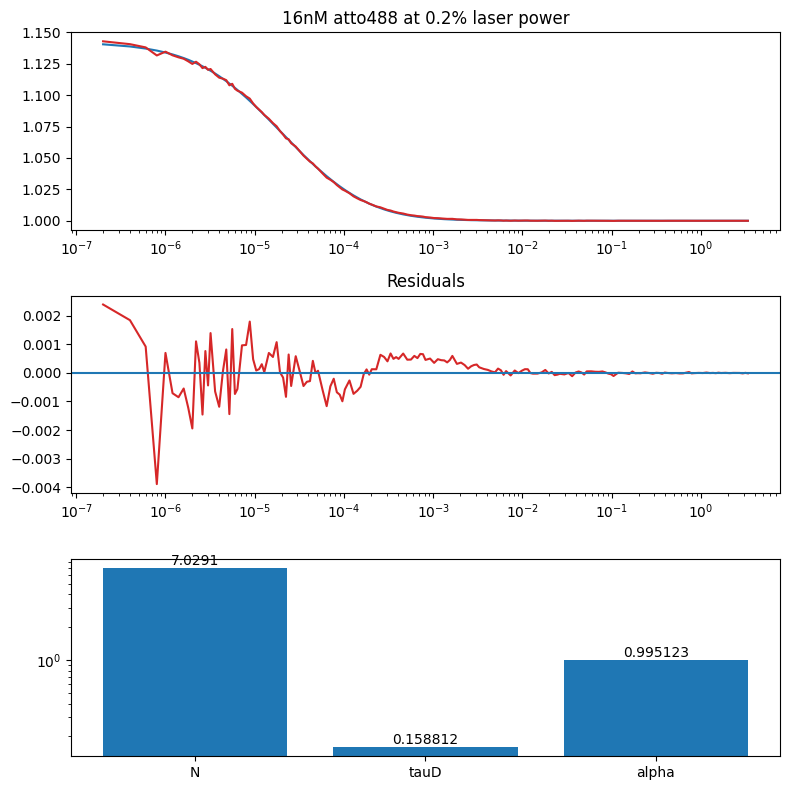

In [100]:
data = fcs.ConfoCor3Fcs('atto488_16nM_laser0p2.fcs')
times_counts, all_counts, times_corr, all_corr, mean_corr, bins_hist, sum_hist = fcs_extract(data)
plot_fit(times_corr, mean_corr, f_anomalous, text="16nM atto488 at 0.2% laser power")

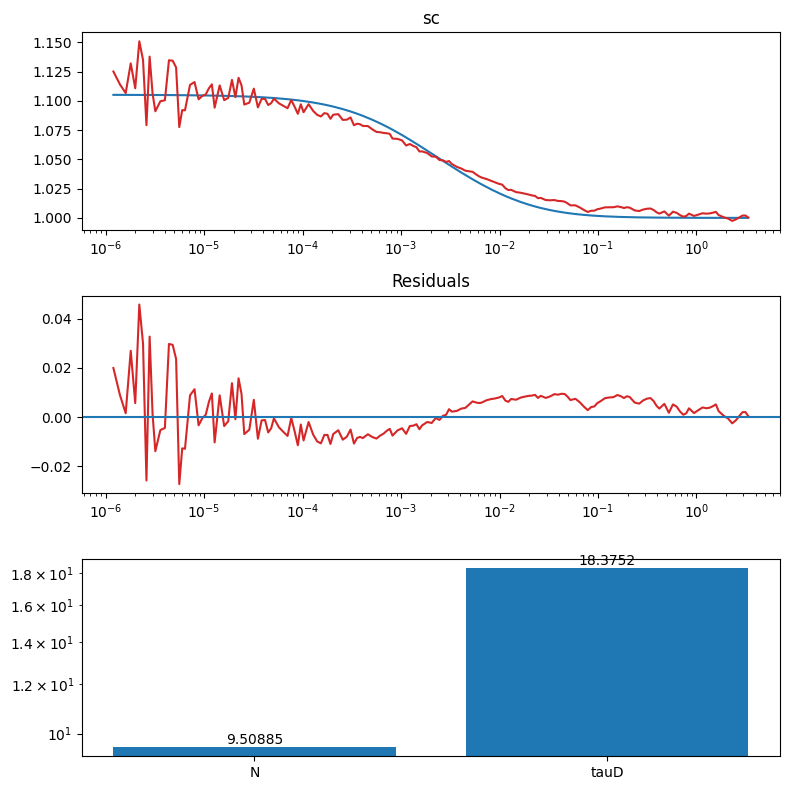

In [148]:
data = fcs.ConfoCor3Fcs('ScBem1GFP_expt2_3roi_laser0p05.fcs')
times_counts, all_counts, times_corr, all_corr, mean_corr, bins_hist, sum_hist = fcs_extract(data, replicates=(23,23))
plot_fit(times_corr[5:], mean_corr[5:], f, text="sc")

In [156]:
# Volume Controlled FCS

Gt = ( ) / ( )

Wr = np.exp()

ValueError: could not broadcast input array from shape (0,) into shape (781,)